# Price Prediction Model

## Libraries

In [34]:
import pandas as pd
import warnings
import pickle
from joblib import dump, load
import numpy as np
import matplotlib.pyplot as plt
import math
warnings.filterwarnings('ignore')

# Scikit learn libraries
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# XGBoost
from xgboost import XGBRegressor
import xgboost as xgb

# Bokeh
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource, Range1d
output_notebook()

Loading BokehJS ...

## Read in our data

In [35]:
df = pd.read_csv('preprocess_data.csv').drop('Unnamed: 0', axis=1)
df.dropna(inplace=True)

## Create train, validation and test sets
We will use SKLearn to split our data into three sets: train, validation and tests sets. The volumes of data will be 70%, 15% and 15% respectively.

In [36]:
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = (train_test_split(
    X, y, test_size=0.4, random_state=42))
X_validation, X_test, y_validation, y_test = (train_test_split(
    X_test, y_test, test_size=0.5, random_state=42))

In [37]:
X_train.shape

(5894, 54)

In [38]:
X_validation.shape

(1965, 54)

In [39]:
X_test.shape

(1965, 54)

## Shallow Models
We will first try out a variety of regression models from Scikit Learn. The following models will be fit:
- Simple Regression
- Support Vector Machines
- Random Forest
- Ada Boost

We will do a generic Grid Search over these models and then look at the MSE on the training set. The model with the best MSE will be futher optimized through an intensive Grid Search over the tuning parameters. This final model will be our top shallow model classifier. We will then build out a Deep Neural Network (DNN) using Keras and compare that more complex model to our top shallow classifier.

### Success Metric
We will use mean squared error (MSE) as our main metric. This will represent the amount of dollars we are off in our prediction. Because our response has undergone a log transformation we will need to undo this to get our actual error. This should be interpreted as the average amount of dollars we are off by.

## Models

### OLS

In [43]:
# Define linear regression grid parameters
lr_grid_parameters = {'fit_intercept': [True, False],
                      'normalize': [True, False]}

# Create our grid search
lr_grid = GridSearchCV(estimator=LinearRegression(), 
                       param_grid=lr_grid_parameters, 
                       scoring='neg_mean_squared_error', 
                       cv=5)

# Fit the model
lr_grid.fit(X_train,y_train)

# Predict on validation set
lr_predictions = lr_grid.predict(X_validation)
lr_mse = mean_squared_error(lr_predictions, y_validation)
lr_mse

0.0738715641041097

#### Export the Linear Regression Model

In [44]:
dump(lr_grid, 'linear_regression.joblib') 

['linear_regression.joblib']

### Support Vector Machine

In [ ]:
# # Define the random forest grid parameters
# svr_grid_parameters = {'kernel': ['rbf', 'poly'],
#                       'degree': [2, 3, 4],
#                       'C': [.01, .1, 1, 10]}

# # Create the grid search
# svm_grid = GridSearchCV(estimator=SVR(), 
#                        param_grid=svr_grid_parameters, 
#                        scoring='neg_mean_squared_error', 
#                        cv=5)

# # Fit the Random Forest grid
# svm_grid.fit(X,y)

# # Return the best score of our RF Grid
# svm_grid.best_score_

#### Dump the SVR model

In [ ]:
# dump(svm_grid, 'svr.joblib') 

### Random Forest

In [45]:
# Define the random forest grid parameters
rf_grid_parameters = {'n_estimators': [100, 300, 500],
                     'max_depth': [None, 3, 5],
                      'min_samples_leaf': [1, 3],
                      'n_jobs': [-1]}

# Create the grid search
rf_grid = GridSearchCV(estimator=RandomForestRegressor(), 
                       param_grid=rf_grid_parameters, 
                       scoring='neg_mean_squared_error', 
                       cv=5)

# Fit the Random Forest grid
rf_grid.fit(X,y)

# Predict on validation set
rf_predictions = rf_grid.predict(X_validation)
rf_mse = mean_squared_error(rf_predictions, y_validation)
rf_mse

0.029076424824688658

#### Export the Random Forest model

In [ ]:
dump(rf_grid, 'random_forest.joblib') 

#### Feature Importances

In [ ]:
featureImportances = (pd.DataFrame
                           (data={'Feature': X_train.columns, 
                                  'Importance':rf_grid.best_estimator_.feature_importances_}))
featureImportances = featureImportances.sort_values(by='Importance', ascending=True)
featureImportances.set_index('Feature', inplace=True)
fig, ax = plt.subplots(figsize=(12, 14))
featureImportances.plot(kind='barh', color='blue', ax=ax)
plt.show()

### XGBoost

In [49]:
# Define the random forest grid parameters
xgb_grid_parameters = {'n_estimators': [100, 300, 500],
                       'max_depth': [3, 11, 19, 27],
                     'learning_rate': [.001, .01, .1]}


# Create the grid search
xgb_grid = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), 
                       param_grid=xgb_grid_parameters, 
                       scoring='neg_mean_squared_error', 
                       cv=5)

# Fit the Random Forest grid
xgb_grid.fit(X_train, y_train)

# Predict on validation set
xgb_predictions = xgb_grid.predict(X_validation)
xgb_mse = mean_squared_error(xgb_predictions, y_validation)
xgb_mse


KeyboardInterrupt



#### Export the XGBoost Classifier

In [ ]:
dump(xgb_grid, 'xgboost.joblib') 

## Optimize XGBoost Model
After reviewing all of our shallow models we see that XGBoost (not surprisingly) has the lowest MSE. We will now turn to optimizing the tuning parameters of XGBoost. This will done in steps.

### Optimize Number of Estimators

In [8]:
# Define our classifier
xgb = XGBRegressor(n_estimators=50000,
                  objective='reg:squarederror',
                  max_depth=3,
                  subsample=.8)

# Fit our classifier
xgb.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_validation, y_validation)],
       eval_metric=['rmse'],
       verbose=0,
       early_stopping_rounds=10)

# Return the iteration with the best results before stopping criteria is bet
xgb.best_iteration

340

#### Plot Learning Curves

In [9]:
results = xgb.evals_result()
training_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# Create the chart
p = figure(sizing_mode='stretch_width', title='XGBoost Training and Validation Error')
p.line(x=list(range(len(training_errors))), y=training_errors, legend='Train')
p.line(x=list(range(len(training_errors))), y=validation_errors, legend='Validation', color='orange')
p.x_range = Range1d(0, 100)
show(p)

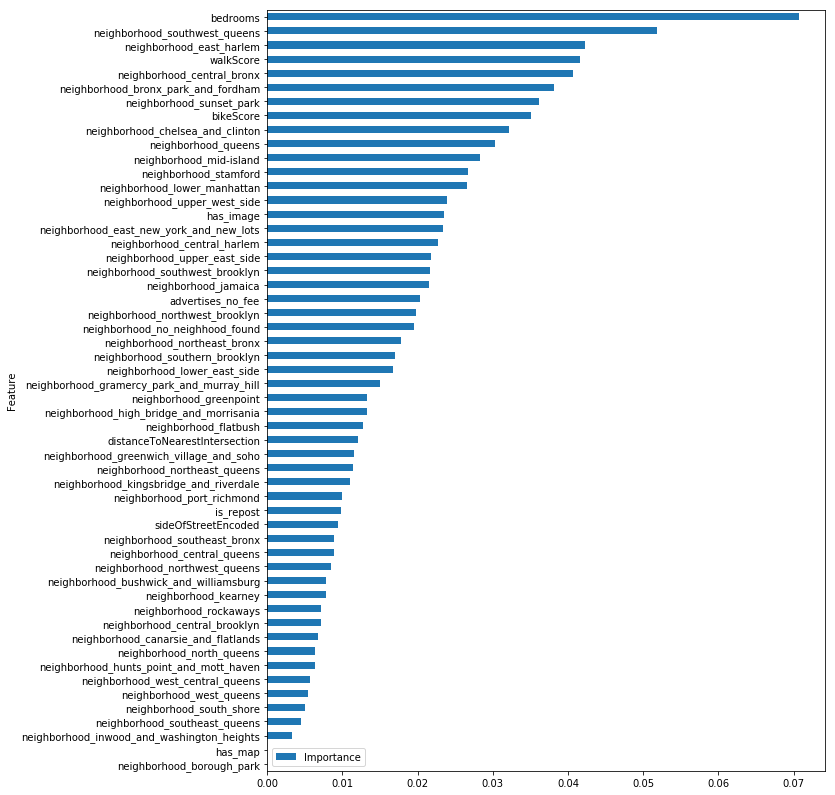

In [10]:
feature_importances = (pd.DataFrame(
                            data={'Feature': X_train.columns, 'Importance': xgb.feature_importances_})
                      .sort_values(by='Importance'))
feature_importances.set_index('Feature', inplace=True)
fig, ax = plt.subplots(figsize=(10,14))
feature_importances.plot(kind='barh', ax=ax)

### Optimize max_depth

In [13]:
param_grid = {'max_depth': range(1, 51, 6)}

clf = XGBRegressor(n_estimators=60, scoring='reg:squarederror', verbose=0, verbose_eval=False)

xgb_grid_estimators = (GridSearchCV(
                        estimator=clf,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        verbose=0))

# Fit the grid
xgb_grid_estimators.fit(X_train, y_train)

[16:39:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:44] WARNI

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=No...uarederror', seed=None, silent=None, subsample=1,
       verbose=0, verbose_eval=False, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(1, 51, 6)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [15]:
def plot_cv_results(fitted_grid):
    results = pd.DataFrame(fitted_grid.cv_results_['params'])
    results['mean_train_score'] = abs(fitted_grid.cv_results_['mean_train_score'])
    
    # Create figure
    source = ColumnDataSource(results)
    p = (figure(sizing_mode='stretch_width', 
                title="Training Error vs. {}".format(results.columns[0]),
                tools=[], 
                toolbar_location=None))
    p.line(x=results.columns[0], y='mean_train_score', source=source)
    show(p)
    
    return results

    

plot_cv_results(xgb_grid_estimators)

,max_depth,mean_train_score
0,1,0.078771
1,7,0.042448
2,13,0.022074
3,19,0.011559
4,25,0.009023
5,31,0.008064
6,37,0.008015
7,43,0.007994
8,49,0.007999


### Optimize Learning Rate

In [20]:
param_grid = {'learning_rate': np.arange(.001, .1, .01)}

clf = XGBRegressor(n_estimators=60, max_depth=30, scoring='reg:squarederror', verbose=0, verbose_eval=False)

xgb_grid_learning_rate = (GridSearchCV(
                        estimator=clf,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        verbose=0))

# Fit the grid
xgb_grid_learning_rate.fit(X_train, y_train)

[16:46:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:46:06] WARNI

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=N...uarederror', seed=None, silent=None, subsample=1,
       verbose=0, verbose_eval=False, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': array([0.001, 0.011, 0.021, 0.031, 0.041, 0.051, 0.061, 0.071, 0.081,
       0.091])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [21]:
plot_cv_results(xgb_grid_learning_rate)

,learning_rate,mean_train_score
0,0.001,48.374088
1,0.011,14.548153
2,0.021,4.362174
3,0.031,1.325873
4,0.041,0.423838
5,0.051,0.149006
6,0.061,0.058888
7,0.071,0.026997
8,0.081,0.015120
9,0.091,0.010197


### Optimize colsample_bytree

In [25]:
param_grid = {'colsample_bytree': np.arange(.3, 1, .05)}

clf = XGBRegressor(n_estimators=60, max_depth=30, scoring='reg:squarederror', verbose=0, verbose_eval=False)

xgb_grid_colsample = (GridSearchCV(
                        estimator=clf,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        verbose=0))

# Fit the grid
xgb_grid_colsample.fit(X_train, y_train)

[17:32:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:25] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:26] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:32:27] WARNI

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=N...uarederror', seed=None, silent=None, subsample=1,
       verbose=0, verbose_eval=False, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'colsample_bytree': array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
       0.85, 0.9 , 0.95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [26]:
plot_cv_results(xgb_grid_colsample)

,colsample_bytree,mean_train_score
0,0.30,0.029777
1,0.35,0.024877
2,0.40,0.020354
3,0.45,0.017029
4,0.50,0.014802
5,0.55,0.014186
6,0.60,0.012583
7,0.65,0.011190
8,0.70,0.010512
9,0.75,0.009854


### Optimize subsample

In [28]:
param_grid = {'subsample': np.arange(.3, 1, .05)}

clf = XGBRegressor(n_estimators=60, 
                   max_depth=30, 
                   colsample_bytree=.9,
                   scoring='reg:squarederror', verbose=0, verbose_eval=False)

xgb_grid_subsample = (GridSearchCV(
                        estimator=clf,
                        param_grid=param_grid,
                        scoring='neg_mean_squared_error',
                        verbose=0))

# Fit the grid
xgb_grid_subsample.fit(X_train, y_train)

[17:36:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:09] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:11] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:12] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:15] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:16] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[17:36:18] WARNI

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread...uarederror', seed=None, silent=None, subsample=1,
       verbose=0, verbose_eval=False, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'subsample': array([0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 ,
       0.85, 0.9 , 0.95])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [29]:
plot_cv_results(xgb_grid_subsample)

,subsample,mean_train_score
0,0.30,0.023317
1,0.35,0.020376
2,0.40,0.018439
3,0.45,0.016477
4,0.50,0.014984
5,0.55,0.013718
6,0.60,0.012589
7,0.65,0.011716
8,0.70,0.011115
9,0.75,0.010417


## Fit Our Optimized XGBoosted Model

In [31]:
optimized_xgb = XGBRegressor(n_estimators=60, 
                   max_depth=30, 
                   colsample_bytree=.9,
                   subsample=.9,
                   scoring='reg:squarederror', 
                   verbose=0)

# Fit the grid
optimized_xgb.fit(X_train, y_train)

[17:39:59] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=30, min_child_weight=1, missing=None, n_estimators=60,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       scoring='reg:squarederror', seed=None, silent=None, subsample=0.9,
       verbose=0, verbosity=1)

In [33]:
xgb_boost_preds = optimized_xgb.predict(X_validation)
mean_squared_error(xgb_boost_preds, y_validation)

0.05532581572102637